## 2017-10-12 增加了信息传播树的zh

# 单条信息传播的测量与机器学习框架

分析某个话题的信息扩散主要有两种方式。第一种方式是描述包括某个主题下所有信息的扩散情况，比如说“韩国部署萨德”这种政治性事件，一般在微博系统中该主题包含几十甚至成百上千条（原创）微博，既难以收集完成所有的数据，也难以对其进行量化，分析起来比较困难。另外一种方式是仅仅分析和描述一条信息完整的扩散过程，得到按照时间次序每一个转发者的信息，以及转发者相互之间的信息转发情况，进而可以构建单条信息的扩散树。比如，通过发帖者、回帖者相互之间的对话我们可以构建跟帖网络，通过分析每一个转发的信息来源，我们可以得到一个完整的信息转发网络。

在本文中我们主要针对第二种分析信息扩散的方式，即描述单条信息扩散的特征。信息扩散的特征可以从多个维度进行测量，最简单的就是信息扩散的规模，而最主要的是对于信息扩散网络的描述（如广度、深度、级联率），此外还可以从时空角度来测量单条信息的信息扩散，比如信息扩散的时间分布特征（速度、爆发、持续性）、空间分布特征。另外，可以结合信息扩散者的社会网络信息来描述信息扩散的特征，比如计算每个转发者的信息扩散阈值等。

除了对单条信息的诸多方面进行描述，我们也可以分析影响前面信息传播的各种因素。这种分析既可以是采用比较简单的方式，如观察信息扩散的规模与某项统计特征事件是否存在相关关系。也可以采用比较复杂的方式，如我们构建一个机器学习的框架，通过数据预处理、特征工程、特征选择、构建分类器等诸多步骤来定量化分析不同因素对于单条信息传播的影响。


# 1 数据说明

如果要对微博传播进行量化，首先要做的一项工作就是获得大规模有代表性的实证数据。在本文中，我们使用卧龙大数据发起的一个微博传播竞赛的数据，详见[微博传播竞赛](http://www.pkbigdata.com/common/cmpt/%E5%BE%AE%E5%8D%9A%E7%83%AD%E5%BA%A6%E9%A2%84%E6%B5%8B_%E7%AB%9E%E8%B5%9B%E4%BF%A1%E6%81%AF.html)
。在该数据集中，他们抓取了大概约3万条“源微博”数据，这些“源微博”被转发共计超过1784万次，涉及到约800万位用户，用户之间的关注关系超过7亿条。 
可供训练学习的数据包括：一批源微博的转发数据，包括被转发的用户，产生转发行为的用户，微博的内容、发布时间；用户与用户之间的关注关系。 测试集的数据：一批刚刚开始传播的微博转发数据及每条微博（包括转发微博）的内容。参赛者需要学习训练集，然后预测测试集中的微博的传播规模和深度。

近些年，一些研究表明，一条微博发出以后，只需要观察其在之后一小段时间内的转发情况，它的传播规模便可以被预测。但是不同类型的微博会有不同的传播方式，比如明星晒一张生活状态就能得到众多粉丝的热捧，具有较大的传播广度，但是往往在传播深度上稍显不足；相比之下，一些被广泛讨论的新闻类微博往往具有较深的传播深度。也有统计结果显示，一些谣言往往会得到大规模的传播，辟谣类的消息反而得不到广泛关注。不仅如此，我们在热门微博中能看到不少正能量的信息，同时也能看到一些话题被持正反两种不同意见的人掀起讨论热潮。

简而言之，微博初期的传播速度、用户关系、信息类型、内容情感等特征都是影响微博传播规模和深度的重要影响因素。 为预测微博的传播规模，我们收集了大约1-3万条微博及其它们的转发微博，希望参赛者能够结合微博用户的关注关系、微博的内容类型和情感分析以及初期的传播模式，来预测微博的传播规模(传播规模定义：源微博一共有多少人转发)和传播深度（传播深度定义：源微博到其他转发微博的最长距离）。参赛者需要建立模型来模拟微博在社交网络中的传播过程；然后将模型应用于“测试集的微博”，以预测它们转发量以及转发深度的增长。


# 数据下载地址
初赛：[https://pan.baidu.com/s/1dELaBJz](https://pan.baidu.com/s/1dELaBJz)
提取密码：samn

# 所有代码的运行环境
需要依赖：Python2.7，pandas，xgboost，graphlab，treelib，jieba，gensim，scikit-learn，networkx

# 2 数据预处理

## 2.1 构建数据处理的初始化环境

In [1]:
#导入各种要使用的模块
import pandas as pd
import numpy as np
#import graphlab as gl
#from treelib import Tree
#import cPickle as pickle
import pickle
import networkx as nx

gl.get_dependencies()

In [2]:
#构建画图环境
%pylab inline

Populating the interactive namespace from numpy and matplotlib


## 2.2 整理数据格式

In [3]:
#因为pandas读入这个数据有问题，所以得先使用graphlab处理一下该数据
#采用graphlab框架读入trainRepost.txt数据
#trainRepost=gl.SFrame.read_csv('trainRepost.txt',sep = '\x01',header =False)
#trainRepost.save('trainRepost_origin.csv', format='csv')  #可提供trainRepost_origin.csv数据

In [4]:
#采用graphlab框架读入并保存WeiboProfile_train数据
#Weibo_train=gl.SFrame.read_csv('WeiboProfile.train',sep = '\x01',header =False)
#Weibo_train.save('WeiboProfile_train.csv', format='csv') #可提供WeiboProfile_train.csv数据

# 3 关注关系特征的构建

## 3.1 关注关系数据格式的说明
相关用户的关注关系，文件名：userRelations.zip 

字段格式为：用户id1 id1关注的用户id列表     
例如：id1 id2\001id3\001id4 

样例：小张关注了小王、小李和小赵，小王关注了小李和小赵，则数据中表示为：     
小张id 小王id\001小李id\001小赵id     
小王id 小李id\001小赵id 

注意：每行表示一个用户关注的微博用户列表，id1和id2之间空格分隔，用以区分用户和关注列表。分隔符为\001，若用python处理，可以试试\x001

## 3.2 关注关系中需要构建的结构特征

### 3.2.1 发微博节点在关注关系中的结构特征

- 发微博节点的出度：out_degree1
- 发微博节点的入度：in_degree1
- 发微博节点在无向网络中的度：all_degree1
- 发微博节点的双向朋友数量：bi_degree1
- 发微博节点的pagerank值：pagerank1

### 3.2.2 发微博节点和转发微博所有节点在关注关系中的结构特征

发微博节点和所有60分钟内转发微博节点的

- 出度之和：sum_out_degree1
- 入度之和：sum_in_degree1
- 在无向网络中的度之和：sum_all_degree1
- 双向朋友数量之和：sum_bi_degree1
- pagerank值的之和：sum_pagerank1

假设节点数量为$n$,连边的数量为$m$,则网络密度的计算公式为$density=\frac{2m}{n(n-1)}$。

发微博节点和所有60分钟内转发微博节点的：

- 出度链接密度：n1_out_density
- 入度链接密度：n1_in_density
- 无向网络中的链接密度：n1_all_density
- 双向朋友数量：n1_bi_density


## 3.3 关注关系数据中结构特征构建的详细过程

In [70]:
## 导入微博关注关系数据集
##guanzhu_links=gl.SFrame.read_csv('relations.csv')                         #导入全部用户之间的链接关系，可提供该数据
#guanzhu_links=gl.SFrame.read_csv('user_relations.csv', nrows=10000)        #导入少量用户之间的链接关系
guanzhu_links=guanzhu_links.dropna()                                        #删除链接关系中的缺失值
print guanzhu_links.head(10)

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/user_relations.csv

Parsing completed. Parsed 100 lines in 0.68662 secs.

Read 3292401 lines. Lines per second: 2.5191e+06

Read 32926868 lines. Lines per second: 5.15561e+06

Read 62559313 lines. Lines per second: 5.42472e+06

Read 92192352 lines. Lines per second: 5.49769e+06

Read 121825867 lines. Lines per second: 5.53307e+06

Read 151460112 lines. Lines per second: 5.54553e+06

Read 181094373 lines. Lines per second: 5.53728e+06

Read 210727585 lines. Lines per second: 5.53106e+06

Read 240360662 lines. Lines per second: 5.53544e+06

Read 269993111 lines. Lines per second: 5.52587e+06

Read 276579161 lines. Lines per second: 4.94043e+06

Read 306210568 lines. Lines per second: 4.99286e+06

Read 335843660 lines. Lines per second: 5.02661e+06

Read 365476045 lines. Lines per second: 5.05459e+06

Read 395110659 lines. Lines per second: 5.08297e+06

Read 424744392 lines. Lines per second: 5.10668e+06

Read 454377988 lines. Lines per second: 5.12695e+06

Read 484011962 lines. Lines per second: 5.14222e+06

Read 513644672 lines. Lines per second: 5.15465e+06

Read 543278332 lines. Lines per second: 5.17365e+06

Read 572910959 lines. Lines per second: 5.18954e+06

Read 602542363 lines. Lines per second: 5.20091e+06

Read 628880794 lines. Lines per second: 5.20702e+06

Read 658513175 lines. Lines per second: 5.20999e+06

Read 688145063 lines. Lines per second: 5.22054e+06

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/user_relations.csv

Parsing completed. Parsed 700482587 lines in 133.776 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------
+---------+---------+
|   uid1  |   uid2  |
+---------+---------+
| 4534517 | 6571120 |
| 4534517 | 2453117 |
| 4534517 | 6105970 |
| 4534517 | 2666130 |
| 4534517 | 8207859 |
| 4534517 | 1843342 |
| 4534517 | 6342579 |
| 4534517 | 7610017 |
| 4534517 | 8237366 |
| 4534517 | 8236591 |
+---------+---------+
[10 rows x 2 columns]



In [71]:
## 使用SGraph来生成微博用户之间的关系网络G1
G1=gl.SGraph().add_edges(guanzhu_links, src_field = 'uid1', dst_field = 'uid2')
print G1.summary()                                            #做一个简单的信息汇总

{'num_edges': 700434403, 'num_vertices': 7977942}


In [6]:
#G1.save('G1')                                              #可以直接保存该网络的数据，可提供该数据G1
G1= gl.load_sgraph('G1')                                    #也可以将该网络读入到内存空间

In [7]:
users_G1 = G1.get_vertices()                                  #获取网络中所有节点的名称
users_G1.rename({'__id':'id'})                                #将名称重新命名
users_G1.head(10)

id
87442
87619
88814
89844
90916
91044
91220
91283
91415
91420


In [ ]:
#计算每一个节点的出度和入度
user_out_friends = guanzhu_links.groupby('uid1', {'out_friends1' : gl.aggregate.CONCAT('uid2')}) #out_friends
user_out_friends.rename({'uid1': 'id'})

In [52]:
user_in_friends = guanzhu_links.groupby('uid2', {'in_friends1' : gl.aggregate.CONCAT('uid1')})   #in_friends
user_in_friends.rename({'uid2' : 'id'})

id,in_friends1
8342756,[4982260]
3097696,[1686731]
8279084,"[8049434, 3968430,8280045, 7563538, ..."
7226615,"[5331852, 4982260]"
7269716,[4823800]
6482075,[7456076]
5453402,[4823800]
7894256,[5927121]
7591144,[2199577]
5570026,[5927121]


In [59]:
users_G1 = users_G1.join(user_in_friends, on = 'id', how = 'outer')   
users_G1 = users_G1.join(user_out_friends, on = 'id', how = 'outer')

#在下面使用空列表来代替缺失值
users_G1 = users_G1.fillna('in_friends1', [ ])
users_G1 = users_G1.fillna('out_friends1', [ ])
users_G1.head(10)

id,in_friends1,out_friends1
8342756,[4982260],[]
3097696,[1686731],[]
8279084,"[8049434, 3968430,8280045, 7563538, ...",[]
7226615,"[5331852, 4982260]",[]
7269716,[4823800],[]
6482075,[7456076],[]
5453402,[4823800],[]
7894256,[5927121],[]
7591144,[2199577],[]
5570026,[5927121],[]


In [60]:
#out_degree - number of users each vertex is following 
users_G1['out_degree1'] = users_G1["out_friends1"].apply(lambda l: len(l) ) 

#in_degree - number of users following each vertex 
users_G1['in_degree1'] = users_G1["in_friends1"].apply(lambda l: len(l) ) 

#all_degree - number of uniuqe users that following or are followed by each user 
users_G1['all_friends1'] = users_G1[['in_friends1', 'out_friends1']].apply(lambda r: list(set(r['in_friends1']) | set(r['out_friends1'])))#并集
users_G1['all_degree1'] = users_G1["all_friends1"].apply(lambda l: len(l) ) 

#bi_degree - number of uniuqe users that are both following and followed by each user 
users_G1['bi_friends1'] = users_G1[['in_friends1', 'out_friends1']].apply(lambda r: list(set(r['in_friends1']) & set(r['out_friends1'])))#交集
users_G1['bi_degree1'] = users_G1["bi_friends1"].apply(lambda l: len(l) ) 

users_G1.head(10)

id,in_friends1,out_friends1,out_degree1,in_degree1,all_friends1,all_degree1
8342756,[4982260],[],0,1,[4982260.0],1
3097696,[1686731],[],0,1,[1686731.0],1
8279084,"[8049434, 3968430,8280045, 7563538, ...",[],0,7,"[7563538.0, 2432261.0,6712486.0, 6534809.0, ...",7
7226615,"[5331852, 4982260]",[],0,2,"[5331852.0, 4982260.0]",2
7269716,[4823800],[],0,1,[4823800.0],1
6482075,[7456076],[],0,1,[7456076.0],1
5453402,[4823800],[],0,1,[4823800.0],1
7894256,[5927121],[],0,1,[5927121.0],1
7591144,[2199577],[],0,1,[2199577.0],1
5570026,[5927121],[],0,1,[5927121.0],1


In [68]:
## 计算出每一个节点的pagerank值
pr1 = gl.pagerank.create(G1)
users_G1['pagerank1'] = pr1['graph'].vertices['pagerank'] #add the new pagerank field to the original graph g2
users_G1.head(10)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 5134.85               |

| 2         | 85.9775               |

| 3         | 0                     |

+-----------+-----------------------+

tweet_user,out_degree1,in_degree1,all_degree1,bi_degree1,pagerank1
8342756,0,1,1,0,0.150745614035
3097696,0,1,1,0,0.15
8279084,0,7,7,0,0.15
7226615,0,2,2,0,0.151613924051
7269716,0,1,1,0,0.155658507161
6482075,0,1,1,0,0.153384779453
5453402,0,1,1,0,0.150689189189
7894256,0,1,1,0,0.150435153584
7591144,0,1,1,0,0.15131443299
5570026,0,1,1,0,0.15108974359


In [37]:
#将其保存为csv文件以便今后使用
#users_G1.rename({'id': 'tweet_user'})                      #更改为tweet_user以便进行数据连接
#users_G1.save('users_G1.csv', format='csv')                #可提供该数据users_G1，通过服务器计算的，所以列名字稍有差异


#使用graphlab重新将数据载入到内存空间中
users_G1=gl.SFrame.read_csv('users_G1.csv')
users_G1.head(10)

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/users_G1.csv

Parsing completed. Parsed 100 lines in 0.784528 secs.

Read 1942009 lines. Lines per second: 1.09944e+06

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/users_G1.csv

Parsing completed. Parsed 7977942 lines in 4.24228 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,float,int,int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


tweet_user,pagerank1,out_degree1,in_degree1,all_degree1,bi_degree1
87442,0.150963,0,1,1,0
87619,0.152167,0,1,1,0
88814,0.151342,0,1,1,0
89844,0.151342,0,1,1,0
90916,0.153678,0,1,1,0
91044,0.151316,0,1,1,0
91220,0.154487,0,2,2,0
91283,0.152531,0,1,1,0
91415,0.153186,0,1,1,0
91420,0.153889,0,2,2,0


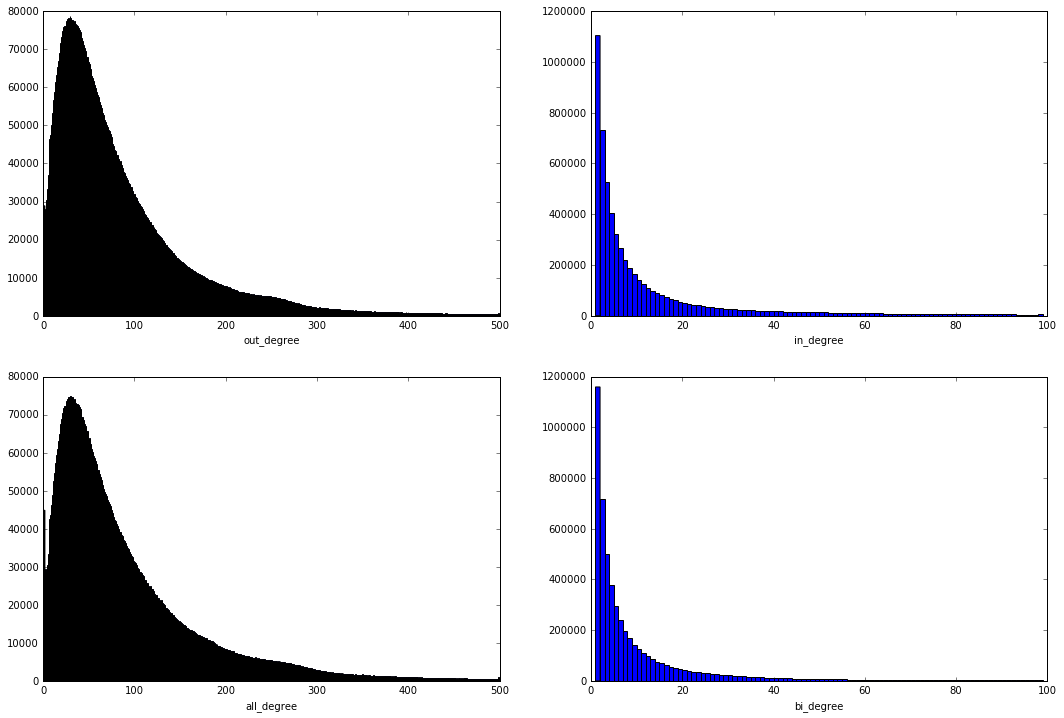

In [6]:
fig = gcf() 
fig.set_size_inches(18, 12)

subplot(2,2,1)
out_degree=users_G1['out_degree1']
hist(out_degree,range(1,500))
xlabel('out_degree')

subplot(2,2,2)
in_degree=users_G1['in_degree1']
hist(in_degree,range(1,100))
xlabel('in_degree')

subplot(2,2,3)
all_degree=users_G1['all_degree1']
hist(all_degree,range(1,500))
xlabel('all_degree')

subplot(2,2,4)
bi_degree=users_G1['bi_degree1']
hist(bi_degree,range(1,100))
xlabel('bi_degree')

savefig("network1_degree.pdf")
#y轴为频数

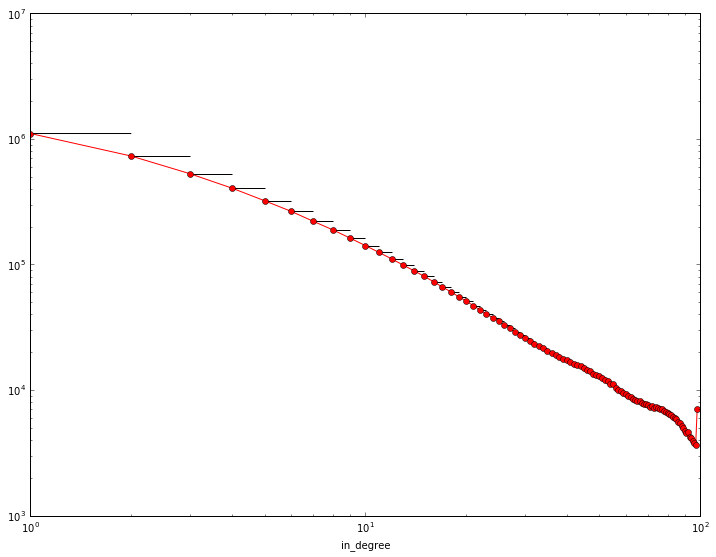

In [56]:
fig = gcf() 
fig.set_size_inches(12, 9)
in_degree=users_G1['in_degree1']
in_degree_hist=hist(in_degree,range(1,100))
xbin=list(in_degree_hist[1])
del xbin[-1]
ybin=list(in_degree_hist[0])
loglog(xbin,ybin,'ro-')
xlabel('in_degree')
savefig("in_degree.pdf")

# 4 微博转发结构和时间特征的构建

## 4.1 原始数据格式的说明
用户微博的转发数据，文件名为trainRepost.txt 

字段格式为：微博id\001被转发用户id\001转发用户id\001转发时间与源微博发表时间的间隔\001微博内容  
样例：小赵在早上7点15分10秒发了一条微博“早上好”，假设记id为weibo1；  
然后按时间先后，过了10s，小王转发了此微博；  
此后又过了20s，小李也转发了；  
再过去30s，小张从小王那里转发了此微博。  

微博上的记录如下：     
小赵：早上好     
小王：早//@小赵：早上好     
小李：早安//@小赵：早上好     
小张：转发微博//@小王：早//@小赵：早上好       
那么微博转发数据中的记录如下：     
weibo1\001小赵id\001小王id\00110\001早    
weibo1\001小赵id\001小李id\00130\001早安     
weibo1\001小王id\001小张id\00160\001    
说明：每行用“回车符”分隔，一行内各字段用“\001”分隔。若转发内容为“转发微博”，我们则省略显示此字段。

## 4.2 转发关系中需要构建的传播特征

### 4.2.1 转发网络中的结构特征
- 节点的出度：out_degree2
- 节点的入度：in_degree2
- 节点在无向网络中的度：all_degree2
- 节点的双向朋友数量：bi_degree2
- 节点的pagerank值：pagerank2

### 4.2.2 转发网络中的时间特征
- 1-60分钟时间内转发的规模：WeiboID,scaleT1,scaleT1…,scaleT60
- 1-60分钟时间内转发的深度：WeiboID,depthT1,depthT1…,depthT60
- 60分钟内的变异系数：差分时间序列的标准差/差分时间序列的均值
- 60分钟内的峰值比率：差分时间序列的最大转发量/总转发量
- 75分钟起每个15分钟一次的总转发规模：WeiboID (Time Unit: Minutes),scaleT75,scaleT90…,scaleT4380
- 75分钟起每个15分钟一次的总转发规模：WeiboID (Time Unit: Minutes),depthT75,depthT90…,depthT4380 

## 4.3 对数据进行读取、设置列名、排序等预处理

### 4.3.1 读取文件trainRepost，设置列名，按照微博号排序

In [152]:
#为每一列起一个名字，方便今后的操作
column_names=['weibo_id','tweet_user','retweet_user','spread_time','content']

#采用pandas框架读入数据
trainRepost=pd.read_csv('trainRepost_origin.csv',header=0,names=column_names)

#未排序前的数据
trainRepost.head(10)

,weibo_id,tweet_user,retweet_user,spread_time,content
0,3903741306239294,2848188,8381213,58674,NaN
1,3972184907435086,5368578,8381203,53713,NaN
2,3903069714925188,6854938,8381203,7828688,NaN
3,3934248572099610,4130595,8381203,299103,NaN
4,3945441579517170,7853791,8381203,11929,@空仕安forever @余瑞廉2013 @吴成军1982
5,3920377703250479,2699651,8381203,3820213,NaN
6,3934928376650489,6666106,8381203,137272,NaN
7,3929327043353030,1639686,8381203,1645635,NaN
8,3811632822151194,5860754,8381203,29320554,NaN
9,3907606521769298,6560549,8381203,8714507,NaN


In [131]:
#查看一下数据长度，看看读取过程是否有问题，正确长度应该为15975388
len(trainRepost)

15975388

In [138]:
#按照微博webo_id,转发时间spread_time, 被转发用户tweet_user，转发用户retweet_user排序，升序排列
#排序后对于创建树形结构是非常有利的
trainRepost.sort_values(by=['weibo_id','spread_time','tweet_user','retweet_user'],ascending=[True,True,True,True])

#排序后的数据
trainRepost.head(10)

,weibo_id,tweet_user,retweet_user,spread_time,content
7329356,3793991852126437,8216045,3558011,114,NaN
13823173,3793991852126437,8216045,3063794,210,很好看，@赵雅芝 新年快乐@陳法蓉 新年快乐，2015祝你幸福，尽快
5502957,3793991852126437,8216045,4785212,450,新年快樂[鼓掌]
13728515,3793991852126437,8216045,3546267,587,NaN
9638528,3793991852126437,8216045,8297102,656,[爱你][爱你]
331786,3793991852126437,8216045,6726058,689,NaN
8715405,3793991852126437,8216045,4748782,693,NaN
11690426,3793991852126437,8216045,5803291,785,NaN
1971640,3793991852126437,8216045,6606949,824,要不要這麼好[花心][花心]2015。幸福的開始
9027973,3793991852126437,8216045,3207988,944,芝姐美美哒😍


In [57]:
#将其保存为csv文件以便今后使用
#trainRepost.to_csv('trainRepost_sort.csv',index=False) #可提供trainRepost_sort.csv数据

#重新将数据载入到内存空间中
trainRepost=pd.read_csv('trainRepost_sort.csv')

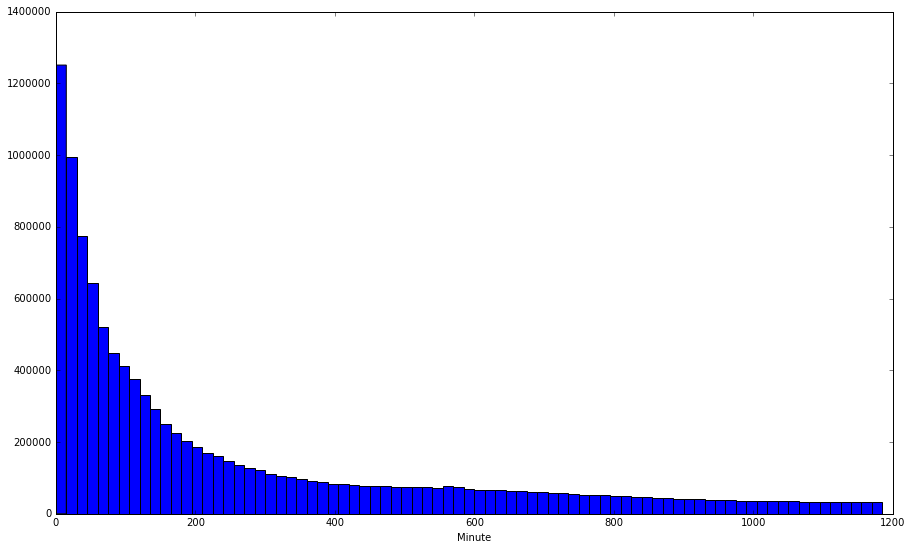

In [59]:
#对传播时间作一个简要的分析
fig = gcf() 
fig.set_size_inches(15, 9)
spread_time=trainRepost['spread_time']/60.0
hist(spread_time,np.arange(0,1200,15))
xlabel('Minute')
savefig("spread_result.pdf")
#由上图可以看出，大量的转发是在前100分钟内完成的，因此前一个小时的转发信息是有可能预测后面的转发情况。

## 4.4 转发关系数据中结构特征构建的详细过程

In [27]:
#zhuanfa_links=trainRepost[['retweet_user','tweet_user','spread_time']]
#zhuanfa_links=zhuanfa_links.dropna()                                               #删除链接关系中的缺失值
#zhuanfa_links.columns = ['src', 'dst','spread_time']

#将其保存为csv文件以便今后使用
#zhuanfa_links.to_csv('zhuanfa_links.csv',index=False)                             #可提供zhuanfa_links.csv数据

#使用graphlab重新将数据载入到内存空间中
zhuanfa_links=gl.SFrame.read_csv('zhuanfa_links.csv')
zhuanfa_links.head(10)

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/zhuanfa_links.csv

Parsing completed. Parsed 100 lines in 0.741369 secs.

Read 2378481 lines. Lines per second: 1.88315e+06

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/zhuanfa_links.csv

Parsing completed. Parsed 15975387 lines in 4.33957 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


src,dst,spread_time
3558011,8216045,114
3063794,8216045,210
4785212,8216045,450
3546267,8216045,587
8297102,8216045,656
6726058,8216045,689
4748782,8216045,693
5803291,8216045,785
6606949,8216045,824
3207988,8216045,944


In [28]:
## 使用SGraph来生成微博用户之间的关系网络G2
G2=gl.SGraph().add_edges(zhuanfa_links, src_field = 'src', dst_field = 'dst')
print G2.summary()  

{'num_edges': 15975387, 'num_vertices': 7445377}


In [9]:
#G2.save('G2')                                                #可以直接保存该网络的数据，可提供转发网络G2的数据
G2= gl.load_sgraph('G2')                                      #将该网络读入到内存空间

In [29]:
users_G2 = G2.get_vertices()                                  #获取网络中所有节点的名称
users_G2.rename({'__id':'id'})                                #将名称重新命名
users_G2.head(10)

id
5
7
8
10
27
29
33
47
52
73


In [30]:
#计算每个节点在转发网络中的出度节点集合
out_friends_sf = zhuanfa_links.groupby("src", {"out_friends2": gl.aggregate.CONCAT("dst")})
out_friends_sf.rename({"src": "id"})
out_friends_sf.head(10)

id,out_friends2
4865614,[7659055]
6120761,[5933434]
6102746,[5844971]
2658191,[4079144]
7839285,[7666083]
1261821,"[8202919, 8202919]"
504649,"[7377993, 5511390]"
7392217,[8253334]
1185276,[7899465]
1968541,[4516159]


In [31]:
#计算每个节点在转发网络中的入度节点集合
in_friends_sf = zhuanfa_links.groupby("dst", {"in_friends2": gl.aggregate.CONCAT("src")})
in_friends_sf.rename({"dst": "id"})
in_friends_sf.head(10)

id,in_friends2
6693645,[6594948]
7506315,[5584488]
6310057,[7904313]
7691878,"[5525981, 5525981]"
6400323,[6400323]
7622051,"[7522772, 7988546,7526782, 7854825, ..."
6723084,[4077516]
4644262,[4292987]
6983937,"[635740, 6243433,4304196] ..."
6011377,"[5774459, 6431916]"


In [32]:
#使用节点的ID将上述数据合并到一起
users_G2 = users_G2.join(in_friends_sf, on="id", how="outer")
users_G2 = users_G2.join(out_friends_sf, on="id", how="outer")

#we replace missing values with empty lists
users_G2 = users_G2.fillna('in_friends2',[])
users_G2 = users_G2.fillna('out_friends2',[])
users_G2.head(10)

id,in_friends2,out_friends2
5,[],[468821]
7,[],[7434393]
8,[],[109619]
10,[],[5496360]
27,[],[8276870]
29,[],[5222540]
33,[],[1068229]
47,[],[5687616]
52,[],[468821]
73,[],[7017144]


In [33]:
#out_degree - number of users each vertex is following
users_G2['out_degree2'] = users_G2["out_friends2"].apply(lambda l: len(l) )

#in_degree - number of users following each vertex
users_G2['in_degree2'] = users_G2["in_friends2"].apply(lambda l: len(l) )

#all_degree - number of uniuqe users that following or are followed by each user
users_G2['all_friends2'] = users_G2[['in_friends2', 'out_friends2']].apply(lambda r: list(set(r['in_friends2']) | set(r['out_friends2'])))#并集
users_G2['all_degree2'] = users_G2["all_friends2"].apply(lambda l: len(l) )

#bi_degree - number of uniuqe users that are both following and followed by each user
users_G2['bi_friends2'] = users_G2[['in_friends2', 'out_friends2']].apply(lambda r: list(set(r['in_friends2']) & set(r['out_friends2'])))#交集
users_G2['bi_degree2'] = users_G2["bi_friends2"].apply(lambda l: len(l) )

users_G2.head(10)

id,in_friends2,out_friends2,out_degree2,in_degree2,all_friends2,all_degree2,bi_friends2,bi_degree2
5,[],[468821],1,0,[468821.0],1,[],0
7,[],[7434393],1,0,[7434393.0],1,[],0
8,[],[109619],1,0,[109619.0],1,[],0
10,[],[5496360],1,0,[5496360.0],1,[],0
27,[],[8276870],1,0,[8276870.0],1,[],0
29,[],[5222540],1,0,[5222540.0],1,[],0
33,[],[1068229],1,0,[1068229.0],1,[],0
47,[],[5687616],1,0,[5687616.0],1,[],0
52,[],[468821],1,0,[468821.0],1,[],0
73,[],[7017144],1,0,[7017144.0],1,[],0


In [34]:
del users_G2['in_friends2']
del users_G2['out_friends2']
del users_G2['all_friends2']
del users_G2['bi_friends2']
users_G2.head(10)

id,out_degree2,in_degree2,all_degree2,bi_degree2
5,1,0,1,0
7,1,0,1,0
8,1,0,1,0
10,1,0,1,0
27,1,0,1,0
29,1,0,1,0
33,1,0,1,0
47,1,0,1,0
52,1,0,1,0
73,1,0,1,0


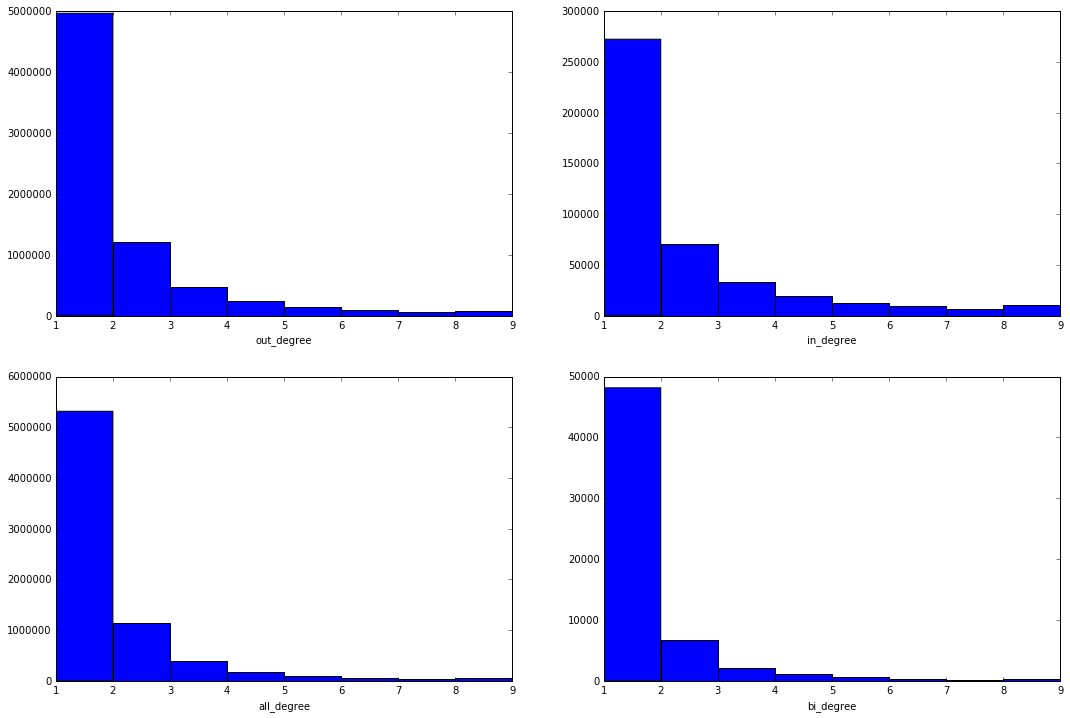

In [61]:
fig = gcf() 
fig.set_size_inches(18, 12)

subplot(2,2,1)
out_degree=users_G2['out_degree2']0
hist(out_degree,range(1,10))
xlabel('out_degree')
page
subplot(2,2,2)
in_degree=users_G2['in_degree2']
hist(in_degree,range(1,10))
xlabel('in_degree')

subplot(2,2,3)
all_degree=users_G2['all_degree2']
hist(all_degree,range(1,10))
xlabel('all_degree')

subplot(2,2,4)
bi_degree=users_G2['bi_degree2']
hist(bi_degree,range(1,10))
xlabel('bi_degree')

savefig("network2_degree.pdf")

In [35]:
## 计算出每一个节点的pagerank值
pr2 = gl.pagerank.create(G2)
users_G2['pagerank2'] = pr2['graph'].vertices['pagerank'] #add the new pagerank field to the original graph g2
users_G2.head(10)

Counting out degree

Done counting out degree

+-----------+-----------------------+

| Iteration | L1 change in pagerank |

+-----------+-----------------------+

| 1         | 1.21098e+07           |

| 2         | 4.82269e+06           |

| 3         | 1.80322e+06           |

| 4         | 801615                |

| 5         | 402386                |

| 6         | 233994                |

| 7         | 149408                |

| 8         | 101659                |

| 9         | 72190.5               |

| 10        | 52508.1               |

| 11        | 38967.6               |

| 12        | 29449.8               |

| 13        | 22513.8               |

| 14        | 17451.7               |

| 15        | 13621.7               |

| 16        | 10758.7               |

| 17        | 8533.38               |

| 18        | 6837.72               |

| 19        | 5502.01               |

| 20        | 4465.61               |

+-----------+-----------------------+

id,out_degree2,in_degree2,all_degree2,bi_degree2,pagerank2
5,1,0,1,0,0.15
7,1,0,1,0,0.15
8,1,0,1,0,0.15
10,1,0,1,0,0.15
27,1,0,1,0,0.15
29,1,0,1,0,0.15
33,1,0,1,0,0.15
47,1,0,1,0,0.15
52,1,0,1,0,0.15
73,1,0,1,0,0.15


In [60]:
#将其保存为csv文件以便今后使用
#users_G2.rename({'id': 'tweet_user'})                              #更改为tweet_user以便进行数据连接
#users_G2.save('users_G2.csv', format='csv')                        #可提供该数据users_G2

#使用graphlab重新将数据载入到内存空间中 
users_G2=gl.SFrame.read_csv('users_G2.csv')
users_G2.head(10)

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/users_G2.csv

Parsing completed. Parsed 100 lines in 1.1541 secs.

Read 2485124 lines. Lines per second: 1.15835e+06

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/users_G2.csv

Parsing completed. Parsed 7445377 lines in 3.47072 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,float]
If parsing fails due to incorrect types, you can correct
the inferred type list above and pass it to read_csv in
the column_type_hints argument
------------------------------------------------------


tweet_user,out_degree2,in_degree2,all_degree2,bi_degree2,pagerank2
5,1,0,1,0,0.15
7,1,0,1,0,0.15
8,1,0,1,0,0.15
10,1,0,1,0,0.15
27,1,0,1,0,0.15
29,1,0,1,0,0.15
33,1,0,1,0,0.15
47,1,0,1,0,0.15
52,1,0,1,0,0.15
73,1,0,1,0,0.15


## 4.5 构建每一条微博传播的级联树结构

### 4.5.1 为构建级联传播树进行数据预处理

In [161]:
#采用pandas框架读入数据
trainRepost=pd.read_csv('trainRepost_sort.csv')

#生成一个所有微博编号的列表
weibo_id_list=trainRepost.weibo_id

#提取列表中有效元素（重复部分数据只取一个），防止创建树时重复创建节点
weibo_id_list=list(np.unique(weibo_id_list))

#去除个别格式有问题的微博数据
weibo_id_list.remove(3793991852126437)
weibo_id_list.remove(3793992178990261)

#这个列表的长度就是有转发级联树微博的数量
len(weibo_id_list)

26992

In [23]:
##将其保存为pkl文件以便今后使用
#pickle_file=open('weibo_id_list.pkl','w')
#pickle.dump(weibo_id_list,pickle_file)                         #可提供该数据weibo_id_list           
#pickle_file.close() 


#采cpickle函数重新读入weibo_id_list数据
pickle_file=open('weibo_id_list.pkl','r')
weibo_id_list=pickle.load(pickle_file)
pickle_file.close()

TypeError: a bytes-like object is required, not 'str'

### 4.5.2 微博传播深度计算的具体说明

以源微博的用户为起点，计算转发链上其他节点到源节点的距离，最长距离就是此微博的传播深度。

举个例子，假如源微博用户是a，用户b从a处转发了微博，用户c从b处转发了微博，用户d又从c处转发了微博，那么微博传播就是a->b->c->d，深度就为3。

但是需要注意三点。

- 第一点：一个用户可能从多个源都做转发，比如在之后的时间里，c从d处进行了转发，或者a又从c处做了转发，在这种情况下，深度并不增加；同样的，若源微博用户a再次转发了自己的微博，深度也不增加。 

- 第二点：若在转发链为a->b->c->d中，出现了新的用户e，从a转发了微博，然后又从d处转发了一次：对于这种情况，我们认为转发链的深度并没有增加，因为e已经被认定为距离a只有1步，此时再从d处转发，并没有实际深度的增加。但需注意，若e先从d处转发，此时传播深度便需要加1，之后e再从a处转发，深度不会降低。 

- 第三点：在数据采集过程中，由于各种原因（比如新浪自动截断、用户手动删除、采集遗漏等），转发链可能出现中断，继续采用上面的例子，假如用户e可能从a、b、c或d中做了转发，但是训练集中没有这一纪录，反倒是有用户f从e处转发了此微博，也就是说无法得知用户e的父亲节点，导致深度计算出现问题。为解决这一问题，我们在计算深度的时候，默认添加从a到e的转发关系，于是从a到e的距离就为1，到f的距离为2。

需要指出的是：在数据采集过程中，由于一些原因可能会出现少量数据遗失的情形，比如 
- (a)用户关注关系的遗失，新产生的关系不能更新 
- (b)在微博转发过程中的用户，有小部分不在用户关注关系数据中 
- (c)转发链可能断裂，比如源微博用户为a，转发链为b转发了a，c转发了b，d转发了c，信息走向就为a->b->c->d，此时深度应为a到d的距离3，但在采集过程中，可能会漏掉b->c这一段，从而导致转发链断裂。此时在计算传播深度的时候，会将转发链视为a->b和a->c->d，深度就计算就取节点a与其他节点的最长距离，即从a到d，深度为2.


In [4]:
#生成每一条级联传播树的核心代码
def spreading_tree(spread_data):
#在生成树形结构以前，应保证原始数据已经进行了排序操作
    parent = list(spread_data['tweet_user'])
    child = list(spread_data['retweet_user'])
    stime=list(spread_data['spread_time'])

    #创建一棵树
    node_tree=Tree()
    
    #创建根节点
    node_tree.create_node(parent[0],parent[0],data=0)
      
    for i in range(len(spread_data)):
        if node_tree.contains(parent[i]):
            try:
                #使用try语句，在父节点相同时，试图创建子节点，若可以创建则创建为子节点，若重复传播无法创建则直接循环下一条语句
                node_tree.create_node(child[i],child[i],parent=parent[i],data=stime[i])
            except:
                pass
        else:
            try:
                #如父节点不在树中，则将父节点设置为根节点，解决传播链断裂的情形
                #(c)转发链可能断裂，比如源微博用户为a，转发链为b转发了a，c转发了b，d转发了c，信息走向就为a->b->c->d，
                #此时深度应为a到d的距离3，但在采集过程中，可能会漏掉b->c这一段，从而导致转发链断裂。此时在计算传播深度的时候，
                #会将转发链视为a->b和a->c->d，深度就计算就取节点a与其他节点的最长距离，即从a到d，深度为2。
                node_tree.create_node(parent[i],parent[i],parent=parent[0],data=stime[i])
                node_tree.create_node(child[i],child[i],parent=parent[i],data=stime[i])
            except:
                pass
                
    return node_tree

In [11]:
#在遍历树的过程中求得传播特性的核心代码
def spreading_results(tree_name):
    #将树结构变成节点的字典形式
    time_dict=tree_name.nodes
    #得到一个键值列表
    keys_list=time_dict.keys()
    
    spread_scale=0
    spread_depth=0
    scale_list=[]
    depth_list=[]
    spread_list=[]
    
    range_scale=list(range(1,61,1))
    range_scale.extend(list(range(61, 181)) + list(range(195, 4380,120)))
    for time_range in range_scale:
        for item in keys_list:
            spread_user_list=[]
            if time_dict[item].data<=time_range*60:
                spread_user_list.append(item)
                #将此时间从key_list中移除
                keys_list.remove(item)

            if len(spread_user_list)>0:
                for retweet_user in spread_user_list:
                    #逐一比较得出最深的树
                    if tree_name.depth(retweet_user)>spread_depth:
                        spread_depth=tree_name.depth(retweet_user)
                        
                #规模为各个时间点的节点长度和
                node_length=len(spread_user_list)
                spread_scale=spread_scale+node_length                                

        scale_list.append(spread_scale-1)
        depth_list.append(spread_depth)

    spread_list=scale_list                                     #返回传播的规模
    spread_list.extend(depth_list)                             #返回传播的深度
    return spread_list

## 4.6 转发关系中时间特征的具体实现

### 4.6.1 提交数据CSV文件的说明
以下均是在60-4380分钟(72小时)内数据进行处理，一方面是作为训练的目标函数用，另一方面在线提交的时候也要有这些结果。

- 提交CSV结果文件，文档中包含每一条微博在不同时刻的传播规模和传播深度。 
- CSV每行字段说明：测试微博id,t1传播规模,t2传播规模,…,tk传播规模,t1传播深度,t2传播深度,…,tk传播深度 
- 每一行为一个微博在某些时刻的传播规模和传播深度。 
- 每列之间逗号分隔，每行之间回车换行。 
- 微博ID的序号，逐行递增；同一微博ID，预测时刻逐列递增。 
- 本次预测的时间间隔为15分钟，预测未来72小时的转发规模增长和传播深度增长。即从微博发出后的第75分钟到第4380分钟，每记录15分钟时的规模和深度，即测试集中有t1＝75，t2=90，......tk＝4380，一共288个时间点。（是4380，不是288，288只是考察的时间点的个数，从75到4380一共是288个时间点，表头也不要删掉）

示例如下，包括表头（第一行），以及从第1条测试微博到第3000条测试微博：

WeiboID (Time Unit: Minutes),scaleT75,scaleT90…,scaleT4380,depthT75,…,depthT4380 

testWeibo1,100,110,…,400,3,…,5 

testWeibo2,15,32,...,720,3,…,12 

… 

testWeibo3000,221,332,...,3200,3,…,14 

注：提交格式一定要与上述格式一致，才能正确计算得分 

### 4.6.2 训练所需时间特征格式的说明 
以下均是在60分钟内数据进行处理，主要是放到训练集中做特征用的。

- 每行字段说明：测试微博id,t1传播规模,t2传播规模,…,tk传播规模,t1传播深度,t2传播深度,…,tk传播深度 
- 每一行为一个微博在某些时刻的传播规模和传播深度。 
- 每列之间逗号分隔，每行之间回车换行。
- 1-60分钟时间内转发的规模：WeiboID,scaleT1,scaleT2…,scaleT60；
- 1-60分钟时间内转发的深度：WeiboID,depthT1,depthT2…,depthT60；
- 1-60分钟时间内转发的宽度：WeiboID,widthT1,widthT2…,widthT60；
- 60分钟内的变异系数：每分钟内转发量的标准差/每分钟内转发量的均值；
- 60分钟内的峰值比率：每分钟内的最大转发量/总转发量；
- 60分钟内的峰值时间：从信息出现到扩散峰值之间的时间；
- 60分钟内的衰减时间：从峰值时间到信息扩散达到扩散规模75%所需的时间；

### 4.6.2 转发关系中时间特征的具体实现过程

In [ ]:
data = pd.read_csv('./')

In [10]:
#做出提交文件中表头的各种字段来，具体的格式如下：
#WeiboID,scaleT1,scaleT2…,scaleT60,scaleT75,scaleT90…,scaleT4380,depthT1,depthT2…,depthT60,depthT75,…,depthT4380 
column_names=[]
column_names.append('weibo_id')
data=[]
range_scale=list(range(1,61,1))

range_scale.extend(list(range(61, 181)) + list(range(195, 4380,120)))

for time_range in range_scale:
    column_names.append('scaleT'+str(time_range))
for time_range in range_scale:
    column_names.append('depthT'+str(time_range))
    
WeiboProfile_train_spreading=pd.DataFrame(data,columns=column_names)
WeiboProfile_train_spreading['weibo_id']=weibo_id_list
WeiboProfile_train_spreading.head(5)

NameError: name 'weibo_id_list' is not defined

In [ ]:
#将数据按照weibo_id进行整合
trainRepost_group=trainRepost.groupby(['weibo_id'])

ID_index=0
for weibo_id in weibo_id_list:
#全部处理时间很长，所以这里面可以设置仅显示处理几条数据
for weibo_id in weibo_id_list:
    if ID_index%1000==0:
        print ID_index
    weibo_id_spread_data=trainRepost_group.get_group(weibo_id)
    tree_name=str(weibo_id)+'_node_tree'
    tree_name=spreading_tree(weibo_id_spread_data)
    weibo_id_spread_results=spreading_results(tree_name)
    weibo_id_spread_results.insert(0,weibo_id)
    WeiboProfile_train_spreading.ix[ID_index]=weibo_id_spread_results
    ID_index=ID_index+1
    
    ##将树文件保存为pkl文件以便今后使用，合计会有2万多棵传播树
    pickle_file=open('treedata/'+'tree_'+str(weibo_id)+'.pkl','w')            #可提供26992棵传播树数据
    pickle.dump(tree_name,pickle_file)
    pickle_file.close()
    
#查看最初的几条数据来验证结果
WeiboProfile_train_spreading.head(10)

In [62]:
#将其保存为csv文件以便今后使用
#该文件得到了每一个weino_id下的的传播情况，在每一时刻该树的深度，根节点被转发的数量
#WeiboProfile_train_spreading.to_csv('WeiboProfile_train_spreading.csv',index=False)

#将已经保存的文件读入到内存中
WeiboProfile_train_spreading=pd.read_csv('WeiboProfile_train_spreading.csv')


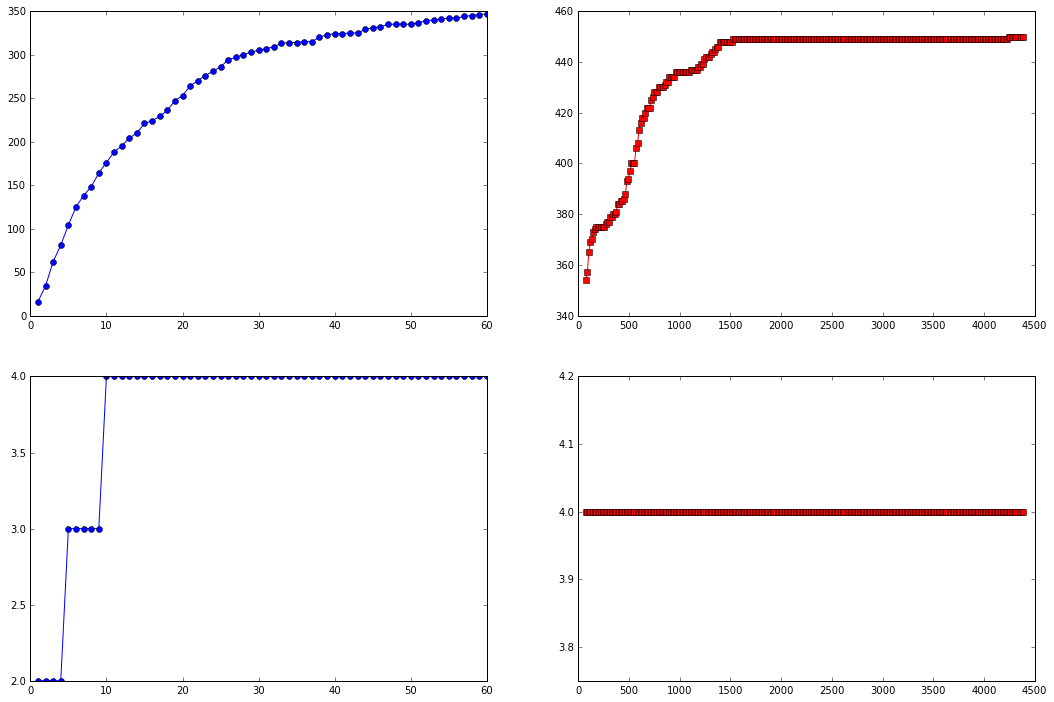

In [63]:
#观察几条微博的传播情况
fig = gcf() 
fig.set_size_inches(18, 12)

subplot(2,2,1)
range_scale1=range(1,61,1)
weibo1_result = WeiboProfile_train_spreading.loc[3]
plot(range_scale1,weibo1_result[1:61],'bo-')

subplot(2,2,2)
range_scale2=range(75,72*61+1,15)
plot(range_scale2,weibo1_result[61:349],'rs-')

subplot(2,2,3)
range_scale1=range(1,61,1)
plot(range_scale1,weibo1_result[349:409],'bo-')

subplot(2,2,4)
range_scale2=range(75,72*61+1,15)
plot(range_scale2,weibo1_result[409:697],'rs-')

savefig("spreading_figure1.pdf")

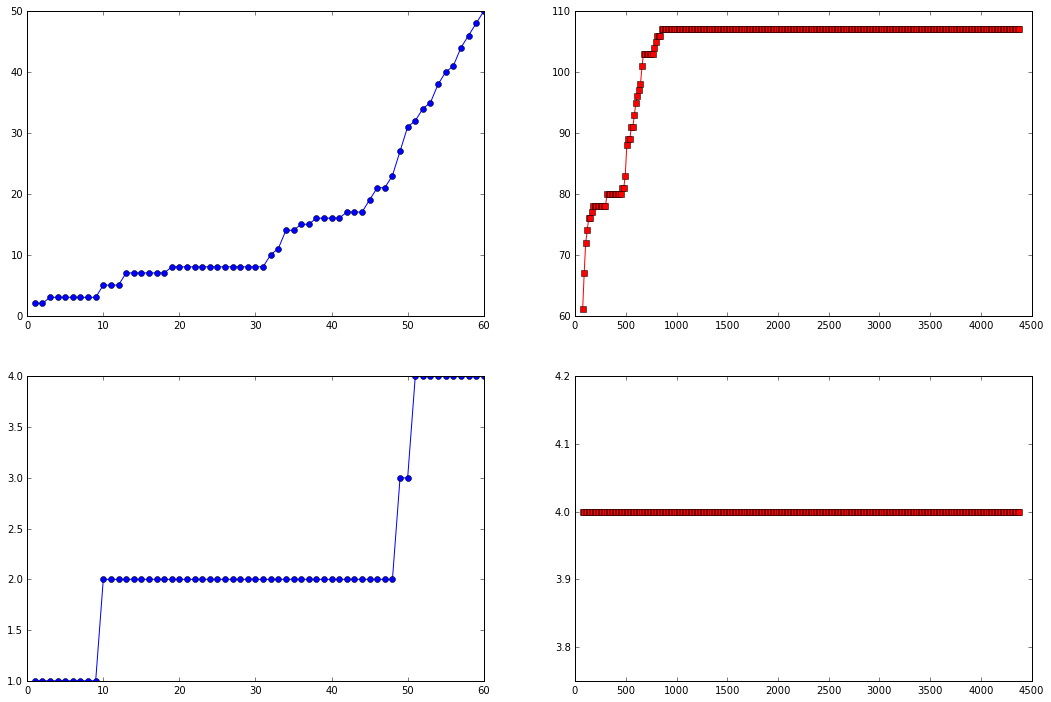

In [65]:
#观察几条微博的传播情况
fig = gcf() 
fig.set_size_inches(18, 12)

subplot(2,2,1)
range_scale1=range(1,61,1)
weibo1_result = WeiboProfile_train_spreading.loc[0]
plot(range_scale1,weibo1_result[1:61],'bo-')

subplot(2,2,2)
range_scale2=range(75,72*61+1,15)
plot(range_scale2,weibo1_result[61:349],'rs-')

subplot(2,2,3)
range_scale1=range(1,61,1)
plot(range_scale1,weibo1_result[349:409],'bo-')

subplot(2,2,4)
range_scale2=range(75,72*61+1,15)
plot(range_scale2,weibo1_result[409:697],'rs-')

savefig("spreading_figure2.pdf")

In [4]:
#读入weibo_id_list数据
pickle_file=open('weibo_id_list.pkl','r')
weibo_id_list=pickle.load(pickle_file)
pickle_file.close()

In [5]:
ID_index=0
#读入结构树数据到内存中
createvar = locals()
for weibo_id in weibo_id_list: #设置读入的传播树个数
    if ID_index%1000==0:      #监测读入的速度
        print ID_index
        
    ID_index=ID_index+1
    pickle_file=open('treedata/'+'tree_'+str(weibo_id)+'.pkl','r')
    varname='tree_'+str(weibo_id)
    createvar[varname]=pickle.load(pickle_file)
    pickle_file.close()

0


## 传播树的例子

In [59]:
print weibo_id_list[0:10]

[3793992191673761, 3793996868052645, 3793997917454642, 3793999469290835, 3794000245281644, 3794000681245277, 3794030854440447, 3794108252024492, 3794110085831316, 3794119669006879]


In [60]:
from treelib import Node, Tree
tree_3793992191673761.show()

3290067
├── 566343
│   ├── 4161583
│   ├── 6244973
│   └── 6984989
│       └── 6822657
├── 1624480
│   ├── 4114209
│   └── 5084576
├── 2211811
├── 2694441
├── 3131381
│   ├── 3014778
│   ├── 3257551
│   ├── 5308558
│   ├── 7888327
│   └── 8234707
├── 3279817
│   ├── 5418325
│   └── 5535391
├── 3497128
│   └── 7950095
├── 3528370
├── 3800625
│   ├── 4883932
│   │   ├── 5979731
│   │   ├── 6356209
│   │   ├── 7253019
│   │   └── 7639694
│   ├── 5171625
│   ├── 5273253
│   ├── 6499692
│   │   ├── 4698194
│   │   ├── 5539573
│   │   └── 7004103
│   ├── 6812245
│   │   ├── 2083524
│   │   ├── 3675525
│   │   │   ├── 3982093
│   │   │   ├── 5506244
│   │   │   ├── 7535246
│   │   │   ├── 7788747
│   │   │   └── 7892016
│   │   ├── 4111043
│   │   ├── 6220772
│   │   └── 8000679
│   ├── 7033925
│   └── 7757693
├── 4202573
├── 4783604
│   ├── 3691627
│   ├── 4196450
│   │   ├── 5409039
│   │   ├── 6224379
│   │   └── 6903390
│   ├── 4790524
│   └── 6497283
├── 4961042
├── 5039913
│   ├── 31300

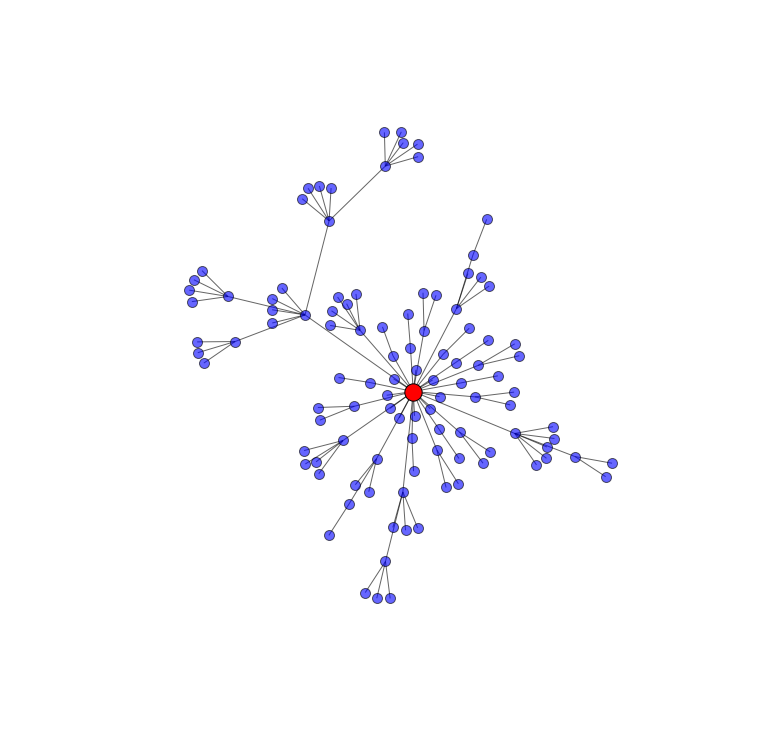

In [61]:
tree_name=tree_3793992191673761
all_nodes = list(tree_name.nodes)    
all_edges = []
for node_i in all_nodes:
    son_list=tree_name.is_branch(node_i)
    if len(son_list)>0:
        for node_j in son_list:
            all_edges.append((node_i,node_j))
            
G = nx.Graph()
G.add_edges_from(all_edges)
root_node=tree_name.root

fig = gcf() 
fig.set_size_inches(10, 10)

#pos = graphviz_layout(G, prog='twopi', args='')
pos = nx.spring_layout(G)
nx.draw(G, pos, node_size=100, alpha=0.6, node_color="blue", with_labels=False)
nx.draw_networkx_nodes(G, pos, nodelist=[root_node], node_size=300, node_color='r')
savefig("ego_network_structure.pdf")

# 5 微博转发内容和发布时间特征的构建

源微博内容（含微博id与内容的对应关系），文件名为WeiboProfile.train 

在例子中，微博的内容就会记录为   
微博id\001微博作者id\001微博发布时刻\001微博内容   
weibo1\001小赵id\00107:15:10\001早上好   
说明：微博发布时刻为当日的时间点，隐藏了日期，并使用24小时计时法。

## 5.1 微博发布时间特征的构建

In [73]:
## 将时分秒转化为小时表示，保存到WeiboProfile_train.csv中
#为每一列起一个名字，方便今后的操作
column_names=['weibo_id','tweet_user','release_time','content']

#采用pandas框架读入数据
WeiboProfile_train=pd.read_csv('WeiboProfile_train_origin.csv',header=0,names=column_names)
WeiboProfile_train.head(10)

,weibo_id,tweet_user,release_time,content
0,3794305741726764,2724513,20:47:26,看到这条微博的人，羊年都会走大运！
1,3794545218812248,7460165,12:39:02,2015你最想获得下面那一项?
2,3794726233244929,7387806,00:38:19,从剧组偷了个闲出来认真的看过沙果“贱”入佳境了，幽默精彩，点赞支持👍，票房小黑马马力十足�...
3,3794986804085757,8091415,17:53:44,"Hey,从事教师这一职业的我不甘于现状，心中总有股劲儿想要挑战自己！一次偶然的机会让我接触了..."
4,3795261795455671,8189779,12:06:27,我操你们妈了隔壁[呵呵]
5,3795438593411753,7298946,23:48:59,[讨论]周杰伦的歌曲和正能量影响着几代人！当然还有现在爆红的00后组合TFBOYS的队长王俊...
6,3795659825938762,7900610,14:28:05,#2015我的开年心愿#圣诞已过，除夕未至。新年伊始，大家一定有新的心愿或者目标：收获一份甜...
7,3795746757084016,8276724,20:13:31,这个时代的基本特质，是虚假，乡愿，半真半假的文化。这是危险的。一个在低级的经济学功利主义下的...
8,3796681650863771,7333613,10:08:27,"《启初婴儿多效倍润面 霜试用体验》我又来抛使用心得了,这次是上市一年多的新品牌“启初”，通过..."
9,3796728916283233,8185330,13:16:16,一年了，真快啊！@刘恺威 @杨幂


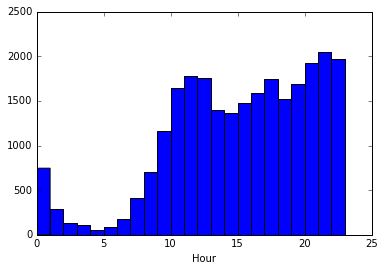

In [74]:
#将发微博的时间转化为xx.xx小时的形式
new_time=[]
for time_item in WeiboProfile_train['release_time']:
    time_split=time_item.split(":")
    new_time.append(float(time_split[0])+float(time_split[1])/60)
WeiboProfile_train.release_time=new_time

#对发微博的时间进行一个初步的分析
fig = gcf() 
fig.set_size_inches(15, 9)
hist(WeiboProfile_train.release_time,np.arange(0,24,1.0))
xlabel('Hour')

#将其保存为csv文件以便今后使用
WeiboProfile_train.to_csv('WeiboProfile_train.csv',index=False)

In [75]:
#这个列表的长度就是训练集样本的数量
len(WeiboProfile_train)
#主要在10点到24点发

26998

## 5.2 对训练集进行文本内容的分类

In [6]:
import re
import jieba 
words_list= []

#处理训练集
WeiboProfile_train=pd.read_csv('WeiboProfile_train.csv')[:]
for item in range(len(WeiboProfile_train)):                                           
        line = str(WeiboProfile_train.content[item]).strip()      
        pipei = re.compile(r'[^\u4e00-\u9fa5]')          #用正则化匹配中文               
        words = " ".join(pipei.split(line)).strip()                      
        words_list.append([j for j in jieba.cut(words)]) #将所有微博的词混合在一起

In [20]:
words_list[:10]

[['看到', '这条', '微博', '的', '人', ' ', '羊年', '都', '会', '走', '大运'],
 ['你', '最', '想', '获得', '下面', '那', '一项'],
 ['从',
  '剧组',
  '偷',
  '了',
  '个',
  '闲',
  '出来',
  '认真',
  '的',
  '看过',
  '沙果',
  ' ',
  '贱',
  ' ',
  '入',
  '佳境',
  '了',
  ' ',
  '幽默',
  '精彩',
  ' ',
  '点赞',
  '支持',
  ' ',
  ' ',
  '票房',
  '小',
  '黑马',
  '马力',
  '十足',
  ' ',
  '祝贺',
  ' ',
  '陈赫',
  ' ',
  '大',
  '荧幕',
  '首秀',
  '成功',
  ' ',
  '红红火火',
  ' ',
  '再创',
  '佳绩',
  ' ',
  '呲',
  '牙',
  ' ',
  ' ',
  '呲',
  '牙',
  ' ',
  ' ',
  '呲',
  '牙'],
 ['从事',
  '教师',
  '这一',
  '职业',
  '的',
  '我',
  '不甘',
  '于',
  '现状',
  ' ',
  '心中',
  '总有',
  '股',
  '劲儿',
  '想要',
  '挑战',
  '自己',
  ' ',
  '一次',
  '偶然',
  '的',
  '机会',
  '让',
  '我',
  '接触',
  '了',
  '微商',
  '逐步',
  '证明',
  '自己',
  ' ',
  '本着',
  ' ',
  '只',
  '做',
  '正品',
  ' ',
  '绝不',
  '碰',
  '假货',
  ' ',
  '的',
  '原则',
  ' ',
  '如今',
  '我',
  '拥有',
  '大批',
  '顾客',
  '和',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  ' ',
  '他们',
  '都',
  '说',
  '我',
  '人缘',
  '好',
  ' ',
  '产品',
  '棒',

In [21]:
WeiboProfile_train['content_cutted'] = words_list
WeiboProfile_train.tail(3)

,weibo_id,tweet_user,release_time,content,content_cutted
26995,3977148597344196,2781527,9.983333,好奇宝宝 http://t.cn/RqsfDtA .,"[好奇, 宝宝]"
26996,3977163906569264,6659676,11.000000,这才是今天我们应该听的歌#CNBLUE#《孤独啊》[doge] http://t.cn/Rq...,"[这才, 是, 今天, 我们, 应该, 听的歌, , , , , , , , ..."
26997,3977170441647435,5239248,11.433333,#钟汉良代言科沃斯#再来一条，你们要的钟汉良[哈哈][哈哈][哈哈] http://t.cn...,"[钟汉良, 代言, 科沃, 斯, , 再, 来, 一条, , 你们, 要, 的, 钟汉良..."


In [22]:
# #处理测试集
# WeiboProfile_test = pd.read_csv('WeiboProfile_test.csv')
# for item in range(len(WeiboProfile_test)):                                           
#         line = str(WeiboProfile_test.content[item]).strip().decode('utf-8', 'ignore')        
#         pipei = re.compile(ur'[^\u4e00-\u9fa5]')          #用正则化匹配中文               
#         words = " ".join(pipei.split(line)).strip()                      
#         words_list.append([j for j in jieba.cut(words)]) #将所有微博的词混合在一起

In [32]:
from gensim import corpora, models, similarities  
dic = corpora.Dictionary(words_list)
corpus = [dic.doc2bow(text) for text in words_list]
tfidf = models.TfidfModel(corpus)
corpus_tfidf = tfidf[corpus]
lda = models.LdaModel(corpus_tfidf, id2word = dic, num_topics = 5)  #将微博内容分成10类
corpus_lda = lda[corpus_tfidf]
# sum1 = len(WeiboProfile_train)

#分别生成训练集内容的标签和测试集内容的标签
# train_category_label = [str(sorted(a,key=lambda x: x[1])[-1][0]) for a in corpus_lda[:sum1]]   #训练集内容的标签
#test_category_label = [str(sorted(a,key=lambda x: x[1])[-1][0]) for a in corpus_lda[sum1:]]    #测试集内容的标签

In [33]:
lda.print_topics(num_words=10)

[(0,
  '0.004*"哈哈哈" + 0.002*"笑" + 0.002*" " + 0.002*"金希澈" + 0.002*"吴世勋" + 0.001*"哈哈哈哈" + 0.001*"头条" + 0.001*"大冒险" + 0.001*"文章" + 0.001*"有点"'),
 (1,
  '0.004*"看盘" + 0.004*"烊" + 0.004*"易" + 0.004*"千玺" + 0.003*"技术" + 0.003*"午间" + 0.003*"股市" + 0.002*"点评" + 0.002*"啊啊啊" + 0.002*"月"'),
 (2,
  '0.008*" " + 0.006*"你" + 0.006*"的" + 0.005*"了" + 0.005*"我" + 0.004*"是" + 0.004*"心" + 0.003*"都" + 0.003*"在" + 0.003*"人"'),
 (3,
  '0.016*" " + 0.011*"全文" + 0.003*"转发" + 0.002*"月" + 0.002*"抽奖" + 0.002*"日" + 0.002*"微博" + 0.002*"元" + 0.001*"分享" + 0.001*"图片"'),
 (4,
  '0.004*"王俊凯" + 0.003*"鹿晗" + 0.002*"宅腐" + 0.002*"杨洋" + 0.001*"蜡烛" + 0.001*"抓狂" + 0.001*"泪" + 0.001*" " + 0.001*"王青" + 0.001*"挖"')]

In [9]:
WeiboProfile_train.head(3)

,weibo_id,tweet_user,release_time,content,content_cutted,content_cutted1
0,3794305741726764,2724513,20.783333,看到这条微博的人，羊年都会走大运！,"[看到, 这条, 微博, 的, 人, , 羊年, 都, 会, 走, 大运]",看到 这条 微博 的 人 羊年 都 会 走 大运
1,3794545218812248,7460165,12.650000,2015你最想获得下面那一项?,"[你, 最, 想, 获得, 下面, 那, 一项]",你 最 想 获得 下面 那 一项
2,3794726233244929,7387806,0.633333,从剧组偷了个闲出来认真的看过沙果“贱”入佳境了，幽默精彩，点赞支持👍，票房小黑马马力十足🐎祝...,"[从, 剧组, 偷, 了, 个, 闲, 出来, 认真, 的, 看过, 沙果, , 贱, ...",从 剧组 偷 了 个 闲 出来 认真 的 看过 沙果 贱 入 佳境 了 幽默 精...


## 5.3 需要构建的训练集文本特征

- 微博的长度：wordlenth
- 包含网址的数量：URL
- 包含Hashtag的数量：Hashtag
- @别人的数量：mention
- 包含照片的数量：picture
- 内容的类别：content_category

# 5.4 训练集文本特征的构建过程

In [78]:
column_names=['weibo_id','tweet_user','release_time','content']
new_column_names=['wordlenth','URL','Hashtag','mention','picture','content_category','hongbao','guanzhu','choujiang']
column_names=column_names+new_column_names
WeiboProfile_train = pd.read_csv('WeiboProfile_train.csv',header = None,names=column_names)  #读取文件
WeiboProfile_train.head(10)

,weibo_id,tweet_user,release_time,content,wordlenth,URL,Hashtag,mention,picture,content_category,hongbao,guanzhu,choujiang
0,weibo_id,tweet_user,release_time,content,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,3794305741726764,2724513,20.7833333333,看到这条微博的人，羊年都会走大运！,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,3794545218812248,7460165,12.65,2015你最想获得下面那一项?,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3794726233244929,7387806,0.633333333333,从剧组偷了个闲出来认真的看过沙果“贱”入佳境了，幽默精彩，点赞支持👍，票房小黑马马力十足�...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3794986804085757,8091415,17.8833333333,"Hey,从事教师这一职业的我不甘于现状，心中总有股劲儿想要挑战自己！一次偶然的机会让我接触了...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,3795261795455671,8189779,12.1,我操你们妈了隔壁[呵呵],NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,3795438593411753,7298946,23.8,[讨论]周杰伦的歌曲和正能量影响着几代人！当然还有现在爆红的00后组合TFBOYS的队长王俊...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,3795659825938762,7900610,14.4666666667,#2015我的开年心愿#圣诞已过，除夕未至。新年伊始，大家一定有新的心愿或者目标：收获一份甜...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,3795746757084016,8276724,20.2166666667,这个时代的基本特质，是虚假，乡愿，半真半假的文化。这是危险的。一个在低级的经济学功利主义下的...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,3796681650863771,7333613,10.1333333333,"《启初婴儿多效倍润面 霜试用体验》我又来抛使用心得了,这次是上市一年多的新品牌“启初”，通过...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [83]:
#新特征1：微博长度
def length(weibodata):
    wordlength = []
    for i in range(len(weibodata)):
        wordlength.append(len(weibodata.content[i]))
    return wordlength

#新特征2：是否包含网址
def URL(weibodata):
    URL = []
    for i in range(len(weibodata)):
        if 'http' in weibodata.content[i]:
            URL.append(1)
        else:
            URL.append(0)
    return URL

#新特征3：是否包含Hashtag
def Hashtag(weibodata):
    Hashtag = []
    for i in range(len(weibodata)):
        if weibodata.content[i].count('#') > 1:
            Hashtag.append(1)
        else:
            Hashtag.append(0)
    return Hashtag

#新特征4：是否包含照片
def picture(weibodata):
    picture = []
    for i in range(len(weibodata)):
        if '【' in weibodata.content[i] or '图' in weibodata.content[i]:
            picture.append(1)
        else:
            picture.append(0)
    return picture

#新特征5：已经提及别人
def mention(weibodata):
    mention = []
    for i in range(len(weibodata)):
        if '@' in weibodata.content[i]:
            mention.append(1)
        else:
            mention.append(0)
    return mention   

In [84]:
#获取训练集的新字段
Weibo_train.wordlenth = Weibo_train['content'].apply(lambda x: length(x))
Weibo_train.URL = Weibo_train['content'].apply(lambda x: URL(x))
Weibo_train.Hashtag = Weibo_train['content'].apply(lambda x: Hashtag(x))
Weibo_train.picture = Weibo_train['content'].apply(lambda x: picture(x))
Weibo_train.mention = Weibo_train['content'].apply(lambda x:mention(x))
Weibo_train=Weibo_train.drop(0) #因为有重复的列
Weibo_train.content_category=list(train_label)
del Weibo_train['content']
Weibo_train.head(10)

#将其保存为csv文件以便今后使用
WeiboProfile_train.to_csv('WeiboProfile_train_processed.csv',index=False)

,weibo_id,tweet_user,release_time,wordlenth,URL,Hashtag,mention,picture,content_category,hongbao,guanzhu,choujiang
1,3794305741726764,2724513,20.7833333333,51,0,0,0,0,0,0,0,0
2,3794545218812248,7460165,12.65,35,0,0,0,0,6,0,0,0
3,3794726233244929,7387806,0.633333333333,226,0,0,1,0,5,0,0,0
4,3794986804085757,8091415,17.8833333333,333,0,0,0,0,9,0,0,0
5,3795261795455671,8189779,12.1,32,0,0,0,0,3,0,0,0
6,3795438593411753,7298946,23.8,359,1,0,1,0,6,0,0,0
7,3795659825938762,7900610,14.4666666667,337,0,1,1,0,6,0,0,0
8,3795746757084016,8276724,20.2166666667,405,0,0,0,0,2,0,0,0
9,3796681650863771,7333613,10.1333333333,415,0,0,0,0,3,0,0,0
10,3796728916283233,8185330,13.2666666667,42,0,0,1,0,0,0,0,0


# 6 线下的训练过程

## 6.1 训练集中各种特征的拼接

In [38]:
#读入各种csv文件到内存空间
#WeiboProfile_train_processed：每条微博对应的文本特征
WeiboProfile_train_processed=pd.read_csv('WeiboProfile_train_processed.csv')

#users_G2：每条微博首发用户对应的传播网络特征
users_G2=pd.read_csv('users_G2.csv')

#基于同一个用户作标示，将上述两个特征进行合并
WeiboProfile_train_tmp1=pd.merge(users_G2,WeiboProfile_train_processed,on='tweet_user', how='inner')

#users_G1：每条微博首发用户对应的结构网络特征
users_G1=pd.read_csv('users_G1.csv')
WeiboProfile_train_tmp=pd.merge(WeiboProfile_train_tmp1,users_G1,on='tweet_user', how='inner')

#WeiboProfile_train_spreading：每一个weino_id下的的传播情况，在每一时刻该树的深度，根节点被转发的数量
WeiboProfile_train_spreading=pd.read_csv('WeiboProfile_train_spreading.csv')

#基于同一个微博作标示，将上述特征进行合并
WeiboProfile_train_final=pd.merge(WeiboProfile_train_tmp,WeiboProfile_train_spreading,on='weibo_id', how='inner')

#将其保存为csv文件以便今后使用
WeiboProfile_train_final.to_csv('WeiboProfile_train_final.csv',index=False)
WeiboProfile_train_final.head(10)

,tweet_user,out_degree2,in_degree2,all_degree2,bi_degree2,pagerank2,weibo_id,release_time,wordlenth,URL,...,depthT4245,depthT4260,depthT4275,depthT4290,depthT4305,depthT4320,depthT4335,depthT4350,depthT4365,depthT4380
0,114011,0,255,252,0,14.1023,3974606387442802,9.616667,392,1,...,6,6,6,6,6,6,6,6,6,6
1,144652,7,1009,920,1,75.5127,3957274441700193,13.766667,96,1,...,7,7,7,7,7,7,7,7,7,7
2,144652,7,1009,920,1,75.5127,3959404967835125,10.866667,173,0,...,8,8,8,8,8,8,8,8,8,8
3,152768,0,547,543,0,77.5759,3954110896652586,20.266667,249,0,...,3,3,3,3,3,3,3,3,3,3
4,155435,0,385,380,0,50.0258,3951263068328236,23.650000,90,1,...,10,10,10,10,10,10,10,10,10,10
5,157223,0,1269,1096,0,82.6330,3958367494594822,14.166667,162,0,...,1,1,1,1,1,1,1,1,1,1
6,157223,0,1269,1096,0,82.6330,3963034382906252,11.233333,14,0,...,1,1,1,1,1,1,1,1,1,1
7,157223,0,1269,1096,0,82.6330,3963022601009002,10.466667,296,0,...,1,1,1,1,1,1,1,1,1,1
8,157245,0,2026,1989,0,218.6380,3966639445423588,10.000000,86,0,...,2,2,2,2,2,2,2,2,2,2
9,157245,0,2026,1989,0,218.6380,3956326495593412,23.000000,67,0,...,4,4,4,4,4,4,4,4,4,4


In [39]:
WeiboProfile_train_final=gl.SFrame.read_csv('WeiboProfile_train_final.csv')
WeiboProfile_train_final.head(10)

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/WeiboProfile_train_final.csv

Parsing completed. Parsed 100 lines in 0.795602 secs.

Read 25027 lines. Lines per second: 12396

Finished parsing file /Users/xiaokeeie/all_datasets/weibojingsai/WeiboProfile_train_final.csv

Parsing completed. Parsed 26955 lines in 2.11722 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,float,int,float,int,int,int,int,int,int,int,int,int,float,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,in

tweet_user,out_degree2,in_degree2,all_degree2,bi_degree2,pagerank2,weibo_id,release_time,wordlenth
114011,0,255,252,0,14.1023,3974606387442802,9.61666666667,392
144652,7,1009,920,1,75.5127,3957274441700193,13.7666666667,96
144652,7,1009,920,1,75.5127,3959404967835125,10.8666666667,173
152768,0,547,543,0,77.5759,3954110896652586,20.2666666667,249
155435,0,385,380,0,50.0258,3951263068328236,23.65,90
157223,0,1269,1096,0,82.633,3958367494594822,14.1666666667,162
157223,0,1269,1096,0,82.633,3963034382906252,11.2333333333,14
157223,0,1269,1096,0,82.633,3963022601009002,10.4666666667,296
157245,0,2026,1989,0,218.638,3966639445423588,10.0,86
157245,0,2026,1989,0,218.638,3956326495593412,23.0,67


In [62]:
#使用graphlab重新将数据载入到内存空间中
WeiboProfile_train_final=gl.SFrame.read_csv('WeiboProfile_train_final.csv')

column_names=[]
range_scale= []
range_scale.extend(range(75,72*61+1,15))

for time_range in range_scale:
    column_names.append('scaleT'+str(time_range))

for item in column_names:
    WeiboProfile_train_final[item]=WeiboProfile_train_final[item]-WeiboProfile_train_final['scaleT60'] ###为什么要减去


train_names=[]

train_names1=[]
train_scale=range(1,61,1)
for time_range in train_scale:
    train_names1.append('scaleT'+str(time_range))
for time_range in train_scale:
    train_names1.append('depthT'+str(time_range))
train_names.extend(train_names1)

#all_degree1-10

train_names2=['out_degree1','in_degree1','all_degree1','bi_degree1','pagerank1']
train_names.extend(train_names2)


train_names3=['out_degree2','in_degree2','all_degree2','bi_degree2','pagerank2']
train_names.extend(train_names3)

train_names4=['release_time','wordlenth','URL','Hashtag','mention','picture','content_category','hongbao','guanzhu','choujiang']
train_names.extend(train_names4)

#训练街测试集划分
train_data, test_data = WeiboProfile_train_final.random_split(0.85)

Finished parsing file /Users/xiaokeeie/all_datasets/xuxiaoke_tutorial/part2_network_spreading/weibo_train_dataset/WeiboProfile_train_final.csv

Parsing completed. Parsed 100 lines in 0.905647 secs.

Read 25027 lines. Lines per second: 14370.5

Finished parsing file /Users/xiaokeeie/all_datasets/xuxiaoke_tutorial/part2_network_spreading/weibo_train_dataset/WeiboProfile_train_final.csv

Parsing completed. Parsed 26955 lines in 1.79989 secs.

------------------------------------------------------
Inferred types from first 100 line(s) of file as 
column_type_hints=[int,int,int,int,int,float,int,float,int,int,int,int,int,int,int,int,int,float,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,int,in

the train and test process for  scaleT75
the train and test process for  scaleT135
the train and test process for  scaleT195
the train and test process for  scaleT255
the train and test process for  scaleT315
the train and test process for  scaleT375
the train and test process for  scaleT435
the train and test process for  scaleT495
the train and test process for  scaleT555
the train and test process for  scaleT615
the train and test process for  scaleT675
the train and test process for  scaleT735
the train and test process for  scaleT795
the train and test process for  scaleT855
the train and test process for  scaleT915
the train and test process for  scaleT975
the train and test process for  scaleT1035
the train and test process for  scaleT1095
the train and test process for  scaleT1155
the train and test process for  scaleT1215
the train and test process for  scaleT1275
the train and test process for  scaleT1335
the train and test process for  scaleT1395
the train and test process f

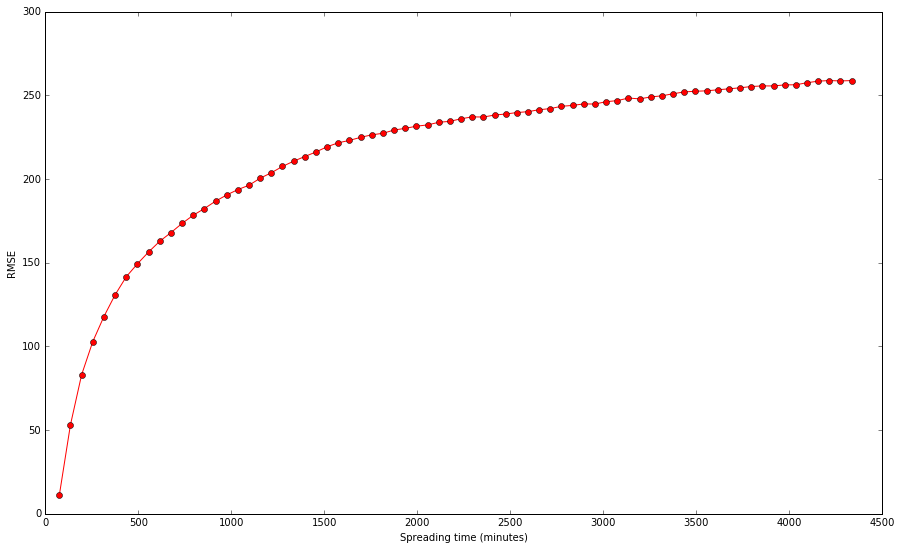

In [65]:
#test_data=WeiboProfile_train_final
test_names=[]

test_onedata=WeiboProfile_train_final[WeiboProfile_train_final['weibo_id']==3794000681245277]
onedata_prediction_scale_results=[]

#验证全部时间范围内的结果
result_tmp=[]
test_scale=range(75,72*61+1,60)

#test_scale=range(75,91,15)
for time_range in test_scale:
    test_names.append('scaleT'+str(time_range))
rmse_scale_results=[]
for test_column in test_names:
    #在这里只使用了1-60分钟的传播规模，传播深度的特征，即scaleT1-scaleT60
    regression_model = gl.random_forest_regression.create(train_data, target=test_column, features = train_names1, verbose=False)
    print "the train and test process for ",test_column
    predictions = regression_model.predict(test_data)
    result_tmp.append(predictions)
    results = regression_model.evaluate(test_data)
    rmse_scale_results.append(results['rmse'])
    
    onedata_prediction = regression_model.predict(test_onedata)
    onedata_prediction_scale_results.append(onedata_prediction)

print "the value of rmse for scale preidction is ",np.mean(rmse_scale_results)

fig = gcf() 
fig.set_size_inches(15, 9)

plot(test_scale,rmse_scale_results,'ro-')
xlabel('Spreading time (minutes)')
ylabel('RMSE')

savefig("testset_scale_result.pdf")

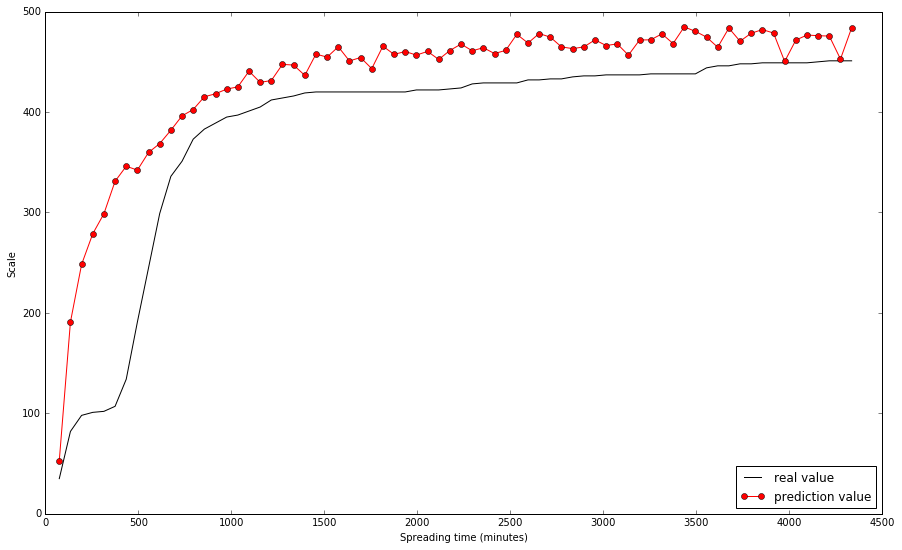

In [96]:
data_prediction=test_onedata[test_names]
one_data_scale=[]
for item in test_names:
    data_tmp=data_prediction[item]
    one_data_scale.extend(list(data_tmp))

fig = gcf() 
fig.set_size_inches(15, 9)

plot(test_scale,one_data_scale,'k-',label='real value')
plot(test_scale,onedata_prediction_scale_results,'ro-',label='prediction value')
xlabel('Spreading time (minutes)')
ylabel('Scale')
legend(loc = 'lower right')

the train and test process for  depthT75
the train and test process for  depthT135
the train and test process for  depthT195
the train and test process for  depthT255
the train and test process for  depthT315
the train and test process for  depthT375
the train and test process for  depthT435
the train and test process for  depthT495
the train and test process for  depthT555
the train and test process for  depthT615
the train and test process for  depthT675
the train and test process for  depthT735
the train and test process for  depthT795
the train and test process for  depthT855
the train and test process for  depthT915
the train and test process for  depthT975
the train and test process for  depthT1035
the train and test process for  depthT1095
the train and test process for  depthT1155
the train and test process for  depthT1215
the train and test process for  depthT1275
the train and test process for  depthT1335
the train and test process for  depthT1395
the train and test process f

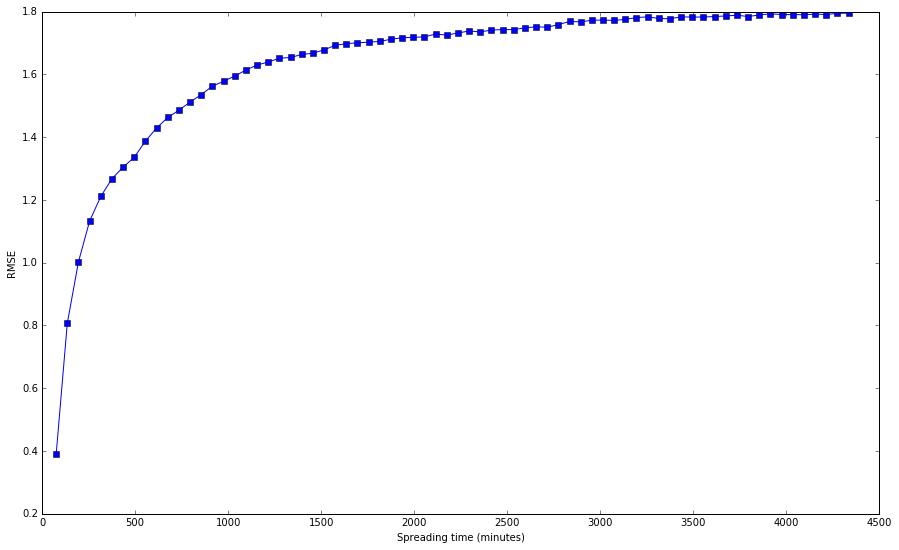

In [97]:
test_names=[]

test_onedata=WeiboProfile_train_final[WeiboProfile_train_final['weibo_id']==3794000681245277]
onedata_prediction_depth_results=[]

#验证全部时间范围内的结果
result_tmp=[]

test_scale=range(75,72*61+1,60)
#test_scale=range(75,72*61+1,300)
for time_range in test_scale:
    test_names.append('depthT'+str(time_range))
    
rmse_depth_results=[]
for test_column in test_names:
    regression_model = gl.random_forest_regression.create(train_data, target=test_column, features = train_names1, verbose=False)
    print "the train and test process for ",test_column
    predictions = regression_model.predict(test_data)
    results = regression_model.evaluate(test_data)
    rmse_depth_results.append(results['rmse'])
    
    onedata_prediction = regression_model.predict(test_onedata)
    onedata_prediction_depth_results.append(onedata_prediction)

print "the value of rmse for scale preidction is ",rmse_depth_results


fig = gcf() 
fig.set_size_inches(15, 9)
plot(test_scale,rmse_depth_results,'bs-')
xlabel('Spreading time (minutes)')
ylabel('RMSE')
savefig("testset_depth_result.pdf")


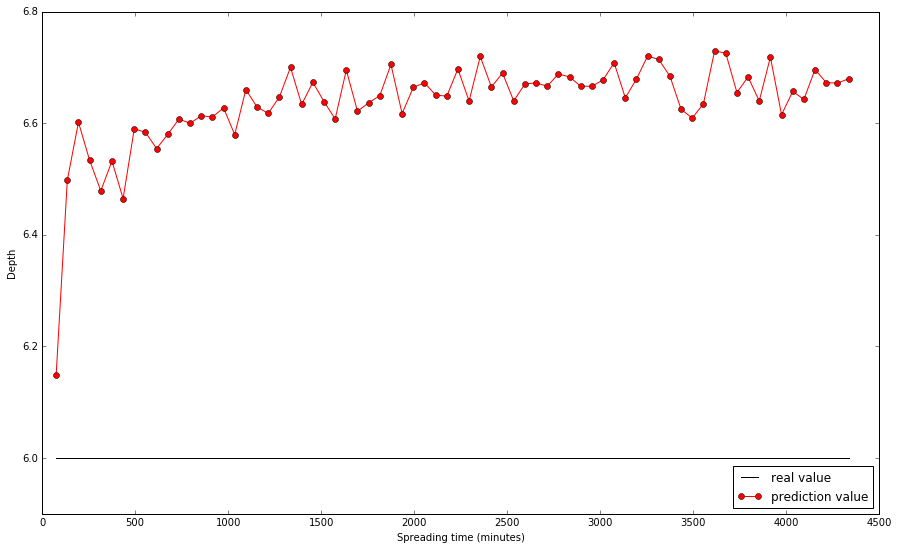

In [99]:
data_prediction=test_onedata[test_names]
one_data_depth=[]
for item in test_names:
    data_tmp=data_prediction[item]
    one_data_depth.extend(list(data_tmp))

fig = gcf() 
fig.set_size_inches(15, 9)

plot(test_scale,one_data_depth,'k-',label='real value')
plot(test_scale,onedata_prediction_depth_results,'ro-',label='prediction value')
xlabel('Spreading time (minutes)')
ylabel('Depth')
legend(loc = 'lower right')

# 基于Xgboost的机器学习框架

//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:112: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
//anaconda/lib/python2.7/site-packages/sklearn/preprocessing/label.py:147: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


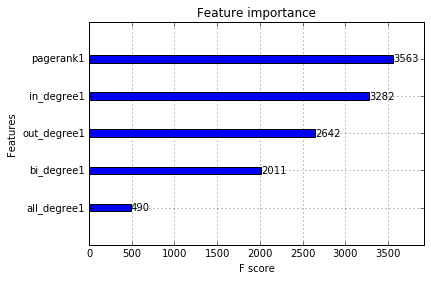

In [7]:
# plot feature importance using built-in function
from xgboost import XGBClassifier
from xgboost import plot_importance
from sklearn.model_selection import train_test_split

#使用pandas重新将数据载入到内存空间中
dataset1=pd.read_csv('WeiboProfile_train_final.csv')

train_names=['out_degree1','in_degree1','all_degree1','bi_degree1','pagerank1']

X = pd.DataFrame(dataset,columns=train_names)
y = pd.DataFrame(dataset,columns=["scaleT75"])

# split data into train and test sets
#seed = 7
#test_size = 0.2
#X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=seed)

# fit model on training data
model = XGBClassifier()
model.fit(X, y)


# plot feature importance
plot_importance(model)